# Tutorial for 8-Point Quadrilateral Element

This notebook is a tutorial covering the 8-point quadrilateral element for FEA meshing aka D2_nn8_quad. 

This element is a quadrilaterial with 8 nodes: 4 at the conters and 4 at the midpoints of the edges. The additional edge nodes allow for greater resolution within the element compared to D2_nn4_quad. Whether this is necessary or not depends on the problem, meshing, etc.

A visualization of the element with 9 Gauss points is shown below:

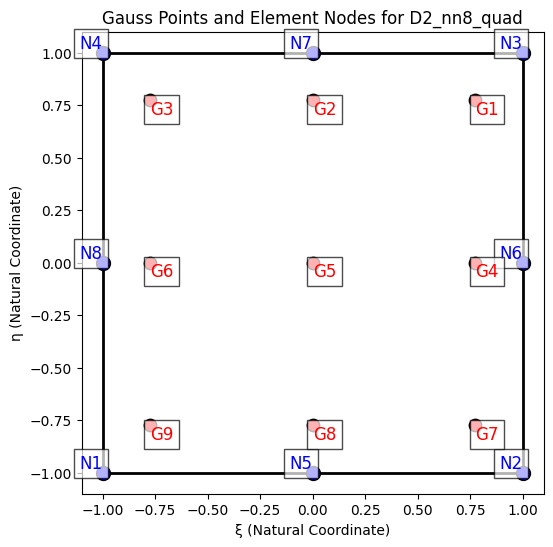

In [1]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo

ele_type = "D2_nn8_quad"
num_gauss_pts = 9
fname = "D2_nn8_quad_9gp.png"
di_demo.visualize_gauss_pts(fname, ele_type, num_gauss_pts)

The nodes shown in blue are used to interpolare fields within the element. The addition of 4 nodes at the edges increases the resolution within these nodes compared to the simpler D2_nn4_quad. The corresponding 9 Gauss points in red are used to numerically integrate over the element.

## Interpolated Fields

Fields within the element are interpolated based on their relative proximity to each node through the use of shape functions. Summing together the contributions from each node gives the interpolated value:

```math
f(\xi, \eta) \approx \sum_{i=1}^8 N_i(\xi, \eta) f(\xi_i, \eta_i)
```

 The closer a point is to a given node, the closer its interpolated value will match it. 

An example of this interpolated field is shown below:

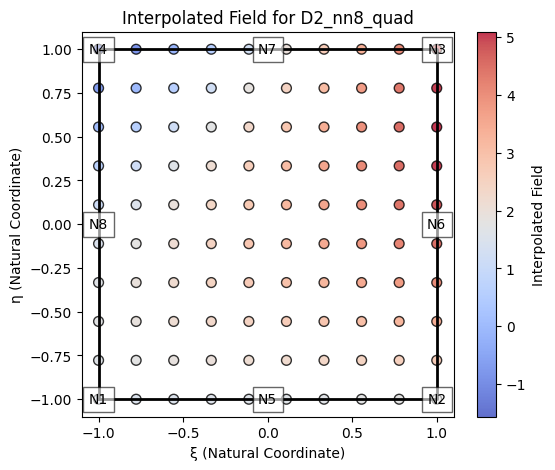

In [2]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(xi, eta):
    return 2.0 * np.sin(xi) + 3.0 * np.cos(eta) + 1.5 * xi * eta

ele_type = "D2_nn8_quad"
node_coords = np.array([[-1, -1], [1, -1], [1, 1], [-1, 1], [0, -1], [1, 0], [0, 1], [-1, 0]])
node_values = np.array([fcn(xi, eta) for xi, eta in node_coords])

fname = ele_type + "_interpolate_fcn.png"
di_demo.plot_interpolate_field_natural_coords_single_element(fname, ele_type, node_values)

## Isoparametric Transformations

So far, the elements we've analyzed have existed inside their natural coordinates. These are a simple set of coordinates that describe the relative position of each node. However, these elements do not exist in these coordinates or shapes;  they can be moved, stretched, rotated, etc. Any transformation that keeps it a quadrilateral is completely valid. We need a way to convert from spatial coordinates to natural coordinates.

Luckily, spatial coordinates can be interpreted as a field we can interpolate. So long as our order of nodes in natural coordinates matches that in spatial coordinates, we can use the same shape functions to interpolate them:

```math
x(\xi, \eta) = \sum_{i=1}^{8} N_i(\xi, \eta) x(\xi_i, \eta_i)
```

So if we want a spatial interpolation, we can use this process to get what we want by find the triplet of $x$, $y$, and $f$ across all values of $\xi$ and $\eta$ and plotting them:

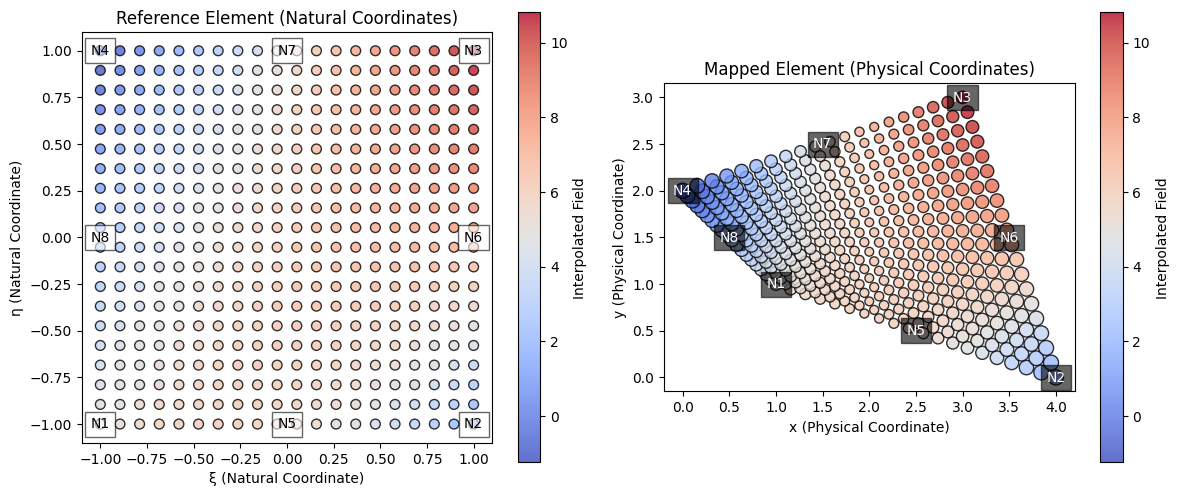

In [3]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 2.0 * np.sin(x) + 3.0 * np.cos(y) + 1.5 * x * y

ele_type = "D2_nn8_quad"
corner_coords = np.array([[1, 1], [4, 0], [3, 3], [0, 2]])
side_coords = np.array([
    (corner_coords[0] + corner_coords[1])/2,
    (corner_coords[1] + corner_coords[2])/2,
    (corner_coords[2] + corner_coords[3])/2,
    (corner_coords[3] + corner_coords[0])/2
])
node_coords = np.append(corner_coords, side_coords, axis=0)
node_values = np.array([fcn(x, y) for x, y in node_coords])
fname = ele_type + "_interpolate_fcn_physical_coords.png"
di_demo.visualize_isoparametric_mapping_single_element(str(fname), ele_type, node_coords, node_values)

## Numerical Differentiation

Now imagine we want to do evaluate a derivative at a location in the element. Let's choose a simple function for now: 

```math 
f(x, y) = 2x + 3y + 1.5xy 
\\
\vec{\nabla} f = \langle1.5y + 2, 1.5x + 3\rangle
```

We want to evaluate this derivative inside the element defined earlier:

In [4]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 2.0 * x + 3.0 * y + 1.5 * x * y

def fcn_deriv(x, y):
    return np.asarray([2.0 + 1.5 * y, 3.0 + 1.5 * x]).reshape((2, 1))

ele_type = "D2_nn8_quad"
corner_coords = np.array([[1, 1], [4, 0], [3, 3], [0, 2]])
side_coords = np.array([
    (corner_coords[0] + corner_coords[1])/2,
    (corner_coords[1] + corner_coords[2])/2,
    (corner_coords[2] + corner_coords[3])/2,
    (corner_coords[3] + corner_coords[0])/2
])
node_coords = np.append(corner_coords, side_coords, axis=0)
node_values = np.array([fcn(x, y) for x, y in node_coords])

xi, eta = 2*(np.random.rand()-0.5), 2*(np.random.rand()-0.5)  # random location inside element

To evaluate this analytically, we have to choose a $\xi, \eta$ pair, convert it, then evaluate it:

In [5]:
# Map the test point from natural to physical coordinates
x_mapped = di_demo.interpolate_field_natural_coords_single_element(
    ele_type, node_coords[:, 0], [xi], [eta]
).flatten()[0]
y_mapped = di_demo.interpolate_field_natural_coords_single_element(
    ele_type, node_coords[:, 1], [xi], [eta]
).flatten()[0]

# Evaluate the function derivative in physical coordinates
mapped_deriv = fcn_deriv(x_mapped, y_mapped)

print(mapped_deriv)

[[5.34415418]
 [5.07847232]]


We can instead evaluate it numerically. To accomplish this, just use the following sum:

```math
\vec{\nabla}_{x, y} f(\xi, \eta) \approx \sum_{i=1}^{8} f_i J^{-T} \vec{\nabla}_{\xi,\eta} N_i \\ \, \\
J = \left[\begin{matrix}
    \frac{\partial x}{\partial \xi} &
    \frac{\partial x}{\partial \eta} \\
    \frac{\partial y}{\partial \xi} &
    \frac{\partial y}{\partial \eta}
\end{matrix}\right]
```

We know our shape functions and node values, so we have everything we need to calculate. We first evaluate the gradient in natural coordinates then transform it to spatial coordinates.

In [6]:
# Compute the numerical gradient in natural coordinates
gradient_natural = di_demo.interpolate_gradient_natural_coords_single_element(
    ele_type, node_values, np.array([xi]), np.array([eta])
)

# Transform the numerical gradient to physical coordinates
gradient_physical = di_demo.transform_gradient_to_physical(
    ele_type, node_coords, np.array([xi]), np.array([eta]), gradient_natural
).reshape((2, 1))

print(gradient_physical)

if np.allclose(mapped_deriv, gradient_physical, atol=1e-10):
    print("analytical and numerical derivatives match!")


[[5.34415418]
 [5.07847232]]
analytical and numerical derivatives match!


## Numerical Integration

So far we've been able to use the element to perform numerical evaluation and differentiation. The last piece is integrating the derivative. We'll be using the same element from before and a slightly different function:

```math
f(x, y) = 3x + 10y \\
\vec{\nabla} f = \langle 3, 10 \rangle
```

In [7]:
from finiteelementanalysis import discretization_demo_helper_fcns as di_demo
import numpy as np

def fcn(x, y):
    return 3.0 * x + 10.0 * y

def fcn_deriv(x, y):
    return np.asarray([3.0, 10.0])  # df/dx = 3.0, df/dy = 10

# Defines element type and coordinates
ele_type = "D2_nn8_quad"
corner_coords = np.array([[1, 1], [4, 0], [3, 3], [0, 2]])
side_coords = np.array([
    (corner_coords[0] + corner_coords[1])/2,
    (corner_coords[1] + corner_coords[2])/2,
    (corner_coords[2] + corner_coords[3])/2,
    (corner_coords[3] + corner_coords[0])/2
])
node_coords = np.append(corner_coords, side_coords, axis=0)
node_values = np.array([fcn(x, y) for x, y in node_coords])

When integrating over the area, we get back a vector along the two axes. The analytical solution to this is simply:

```math
\langle 3A, 10A \rangle
```

where $A$ is the area of the element:

In [8]:
def element_area(node_coords):
    # Function to calculate the area of an element from its corner node locations
    x1, y1 = node_coords[0]
    x2, y2 = node_coords[1]
    x3, y3 = node_coords[2]
    x4, y4 = node_coords[3]
    area = 0.5 * abs((x1 * y2 + x2 * y3 + x3 * y4 + x4 * y1) 
                     - (y1 * x2 + y2 * x3 + y3 * x4 + y4 * x1))
    return area

# Integral of the gradient across the area
def integral_of_deriv(node_coords):
    area = element_area(node_coords)
    return np.array([3.0 * area, 10.0 * area]).reshape((2, 1))

# Compute analytical integral
integral_analytical = integral_of_deriv(node_coords)

print(integral_analytical)

[[18.]
 [60.]]


If we instead want to numerically evaluate it, we can sum at different points in the area. The Gauss points chosen earlier are which points to sum over. For integrating this, we get the following:

```math
\iint_{A} \vec{\nabla} f \, dxdy \approx \sum_{j=1}^9 w_j |J|_j \vec{\nabla} f (x_j, y_j)
```

This is not limited to integrating derivatives. This will work for integrating any function. However, what makes integrating derivatives special is that we have a way to numerically evaluate derivatives. We don't even need to know the derivative function:

In [9]:
# Compute nodal values from fcn(x, y)
nodal_values = np.array([[fcn(x, y) for x, y in node_coords]]).T

# Compute numerical integral of derivative
integral_numerical = di_demo.compute_integral_of_derivative(
    ele_type, num_gauss_pts, node_coords, nodal_values)

print(integral_numerical)

# check result
if np.allclose(integral_numerical, integral_analytical, atol=1e-10):
    print("analytical and numerical integrals of derivatives match!")

[[18.]
 [60.]]
analytical and numerical integrals of derivatives match!


This only covers the use case for a single derivative. For proper analysis, multiple of these elements are connected together through a mesh. The elements act as their own constitutive equations that can then be built up into a single large system.